In this project, we're going to explore a workflow to make competing in the **Kaggle Titanic competition** easier, using a pipeline of functions to reduce the number of dimensions we need to focus on.

In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [70]:
import pandas as pd
train = pd.read_csv("train.csv")
holdout = pd.read_csv("test.csv")

In [71]:
train.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C


One of the many benefits of using Jupyter is that (by default) it uses the [IPython kernel](https://ipython.readthedocs.io/en/stable/) to run code. This gives us all the benefits of IPython, including code completion and **magic** commands. 

We can use one of those magic commands, the [%load command](https://ipython.readthedocs.io/en/stable/interactive/magics.html#magic-load), to load an external file. The `%load` command will copy the contents of the file into the current notebook cell.

In [72]:
# %load functions.py
#!/usr/bin/env python

# In[ ]:


def process_missing(df):
    """Handle various missing values from the data set

    Usage
    ------

    holdout = process_missing(holdout)
    """
    df["Fare"] = df["Fare"].fillna(train["Fare"].mean())
    df["Embarked"] = df["Embarked"].fillna("S")
    return df

def process_age(df):
    """Process the Age column into pre-defined 'bins' 

    Usage
    ------

    train = process_age(train)
    """
    df["Age"] = df["Age"].fillna(-0.5)
    cut_points = [-1,0,5,12,18,35,60,100]
    label_names = ["Missing","Infant","Child","Teenager","Young Adult","Adult","Senior"]
    df["Age_categories"] = pd.cut(df["Age"],cut_points,labels=label_names)
    return df

def process_fare(df):
    """Process the Fare column into pre-defined 'bins' 

    Usage
    ------

    train = process_fare(train)
    """
    cut_points = [-1,12,50,100,1000]
    label_names = ["0-12","12-50","50-100","100+"]
    df["Fare_categories"] = pd.cut(df["Fare"],cut_points,labels=label_names)
    return df

def process_cabin(df):
    """Process the Cabin column into pre-defined 'bins' 

    Usage
    ------

    train process_cabin(train)
    """
    df["Cabin_type"] = df["Cabin"].str[0]
    df["Cabin_type"] = df["Cabin_type"].fillna("Unknown")
    df = df.drop('Cabin',axis=1)
    return df

def process_titles(df):
    """Extract and categorize the title from the name column 

    Usage
    ------

    train = process_titles(train)
    """
    titles = {
        "Mr" :         "Mr",
        "Mme":         "Mrs",
        "Ms":          "Mrs",
        "Mrs" :        "Mrs",
        "Master" :     "Master",
        "Mlle":        "Miss",
        "Miss" :       "Miss",
        "Capt":        "Officer",
        "Col":         "Officer",
        "Major":       "Officer",
        "Dr":          "Officer",
        "Rev":         "Officer",
        "Jonkheer":    "Royalty",
        "Don":         "Royalty",
        "Sir" :        "Royalty",
        "Countess":    "Royalty",
        "Dona":        "Royalty",
        "Lady" :       "Royalty"
    }
    extracted_titles = df["Name"].str.extract(' ([A-Za-z]+)\.',expand=False)
    df["Title"] = extracted_titles.map(titles)
    return df

def create_dummies(df,column_name):
    """Create Dummy Columns (One Hot Encoding) from a single Column

    Usage
    ------

    train = create_dummies(train,"Age")
    """
    dummies = pd.get_dummies(df[column_name],prefix=column_name)
    df = pd.concat([df,dummies],axis=1)
    return df

In [73]:
def pre_process(df):
    df = process_missing(df)
    df = process_age(df)
    df = process_fare(df)
    df = process_titles(df)
    df = process_cabin(df)
    
    for col in ["Age_categories","Fare_categories","Title","Cabin_type","Sex"]:
        df = create_dummies(df,col)
    return df

In [74]:
train = pre_process(train)
holdout = pre_process(holdout)

In the first three project, we have done a variety of activities, mostly in isolation: 
* Exploring the data, 
* creating features, 
* selecting features, 
* selecting and 
* tuning different models.

The Kaggle workflow we are going to build will combine all of these into a process.

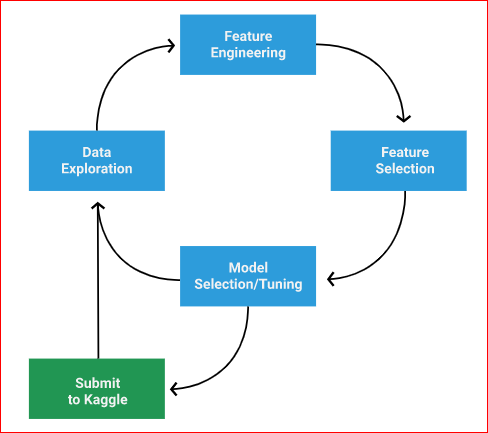

* **Data exploration**, to find patterns in the data
* **Feature engineering**, to create new features from those patterns or through pure experimentation
* **Feature selection**, to select the best subset of our current set of features
* **Model selection/tuning**, training a number of models with different hyperparameters to find the best performer.

We can continue to repeat this cycle as we work to optimize our predictions. At the end of any cycle we wish, we can also use our model to make predictions on the **holdout set** and then Submit to **Kaggle** to get a **leaderboard score**.

We're going to examine the two columns that contain information about the family members each passenger had onboard: `SibSp` and `Parch`.

# Exploring the Data

In [75]:
explore_cols = ["SibSp","Parch","Survived"]
explore = train[explore_cols].copy()
explore.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 3 columns):
SibSp       891 non-null int64
Parch       891 non-null int64
Survived    891 non-null int64
dtypes: int64(3)
memory usage: 21.0 KB


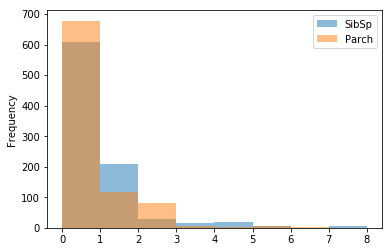

In [76]:
explore.drop("Survived",axis=1).plot.hist(alpha=0.5,bins=8)
plt.show()

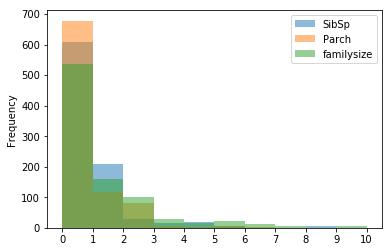

In [77]:
explore["familysize"] = explore[["SibSp","Parch"]].sum(axis = 1)
explore.drop("Survived",axis=1).plot.hist(alpha=0.5,bins=10)
plt.xticks(range(11))
plt.show()

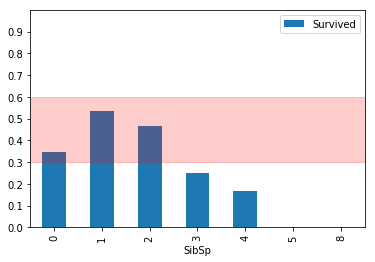

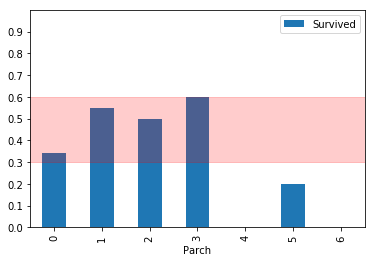

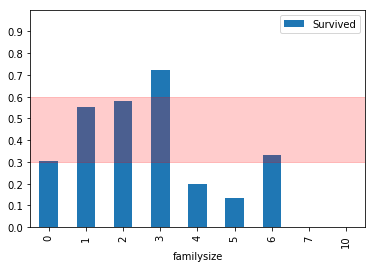

In [78]:
import numpy as np

for col in explore.columns.drop('Survived'):
    pivot = explore.pivot_table(index = col, values = 'Survived')
    pivot.plot.bar(ylim=(0,1), yticks = np.arange(0,1,0.1))
    plt.axhspan(0.3,0.6, alpha = 0.2, color = "red")
    plt.show()

The `SibSp` column shows the **number of siblings and/or spouses each passenger had on board**, while the `Parch` columns shows the **number of parents or children each passenger had onboard**. Neither column has any missing values.

The distribution of values in both columns is **skewed right**, with the majority of values being zero.

We can sum these two columns to explore the total number of family members each passenger had onboard. The shape of the distribution of values in this case is similar, however there are less values at zero, and the quantity tapers off less rapidly as the values increase.

Looking at the survival rates of the the combined family members, we can see that few of the over 500 passengers with no family members (only 30% of the passengers who had no family members onboard ) survived, while greater numbers of passengers with family members survived.

Based of this, we can come up with an idea for a new feature - was the passenger alone. This will be a binary column containing the value:

* `1` if the passenger has zero family members onboard
* `0` if the passenger has one or more family members onboard

# Engineering New Features

In [79]:
def process_isalone(df):
    df["familysize"] = df[["SibSp","Parch"]].sum(axis = 1)
    df["isalone"] = 0
    df.loc[(df["familysize"] == 0), "isalone"] = 1
    df.drop("familysize", axis = 1)
    return df

In [ ]:
train = process_isalone(train)
holdout = process_isalone(holdout)

The next step in our workflow is feature selection. We used **scikit-learn's feature_selection**.`RFECV` class to automate selecting the best-performing features using **recursive feature elimination**.

Let's write a function that:

* Accepts a dataframe as input
* Performs data preparation for machine learning
* Uses recursive feature elimination and the random forests algorithm to find the best-performing set of features

# Selecting the Best-Performing Features

In [80]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV

In [81]:
def select_features(df):
    # Remove non-numeric columns, columns that have null values
    df = df.select_dtypes([np.number]).dropna(axis=1)
    all_X = df.drop(["Survived","PassengerId"],axis=1)
    all_y = df["Survived"]
    
    clf = RandomForestClassifier(random_state=1)
    selector = RFECV(clf,cv=10)
    selector.fit(all_X,all_y)
    
    best_columns = list(all_X.columns[selector.support_])
    return best_columns

In [82]:
cols = select_features(train)
print(cols)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: F

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: F

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: F

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: F

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: F

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: F

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: F

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: F

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: F

['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Age_categories_Missing', 'Age_categories_Infant', 'Age_categories_Child', 'Age_categories_Teenager', 'Age_categories_Young Adult', 'Age_categories_Adult', 'Age_categories_Senior', 'Fare_categories_0-12', 'Fare_categories_12-50', 'Fare_categories_50-100', 'Fare_categories_100+', 'Title_Master', 'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Officer', 'Title_Royalty', 'Cabin_type_A', 'Cabin_type_B', 'Cabin_type_C', 'Cabin_type_D', 'Cabin_type_E', 'Cabin_type_F', 'Cabin_type_G', 'Cabin_type_Unknown', 'Sex_female', 'Sex_male', 'familysize', 'isalone']


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Just like we did with feature selection, we can can write a function to do the heavy lifting of model selection and tuning. The function we'll create will use three different algorithms and use grid search to train using different combinations of hyperparameters to find the best performing model.

We can achieve this by creating a list of dictionaries— that is, a list where each element of the list is a dictionary. Each dictionary should contain:

* The name of the particular model
* An estimator object for the model
* A dictionary of hyperparameters that we'll use for grid search.

# Selecting and Tuning Different Algorithms

In [83]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

In [84]:
def select_model(df,features):
    all_X = df[features]
    all_y = df["Survived"]

    # List of dictionaries, each containing a model name,
    # it's estimator and a dict of hyperparameters
    models = [
        {
            "name": "LogisticRegression",
            "estimator": LogisticRegression(),
            "hyperparameters":
                {
                    "solver": ["newton-cg", "lbfgs", "liblinear"]
                }
        },
        {
            "name": "KNeighborsClassifier",
            "estimator": KNeighborsClassifier(),
            "hyperparameters":
                {
                    "n_neighbors": range(1,20,2),
                    "weights": ["distance", "uniform"],
                    "algorithm": ["ball_tree", "kd_tree", "brute"],
                    "p": [1,2]
                }
        },
        {
            "name": "RandomForestClassifier",
            "estimator": RandomForestClassifier(random_state=1),
            "hyperparameters":
                {
                    "n_estimators": [4, 6, 9],
                    "criterion": ["entropy", "gini"],
                    "max_depth": [2, 5, 10],
                    "max_features": ["log2", "sqrt"],
                    "min_samples_leaf": [1, 5, 8],
                    "min_samples_split": [2, 3, 5]

                }
        }
    ]
    for model in models:
        print(model["name"])
        print("-"*len(model["name"]))
        
        grid = GridSearchCV(model["estimator"],param_grid= model["hyperparameters"], cv = 10)
        grid.fit(all_X, all_y)
        model["best_params"] = grid.best_params_
        model["best_score"] = grid.best_score_
        model["best_model"] = grid.best_estimator_

        print("Best Score: {}".format(model["best_score"]))
        print("Best Parameters: {}\n".format(model["best_params"]))

    return models

            


In [85]:
result = select_model(train,cols)

LogisticRegression
------------------


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", Convergenc

Best Score: 0.8181818181818182
Best Parameters: {'solver': 'newton-cg'}

KNeighborsClassifier
--------------------


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best Score: 0.7800224466891134
Best Parameters: {'algorithm': 'kd_tree', 'n_neighbors': 3, 'p': 1, 'weights': 'uniform'}

RandomForestClassifier
----------------------
Best Score: 0.8406285072951739
Best Parameters: {'criterion': 'entropy', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 9}



After running our function, we have three scores from three different models. At this point in the workflow we have a decision to make: Do we want to train our best model on the holdout set and make a Kaggle submission, or do we want to go back to engineering features.

We may find that adding a feature to our model doesn't improve our accuracy. In that case we should go back to data exploration and repeat the cycle again.

If we're going to be continually submitting to Kaggle, a function will help make this easier. Let's create a function to automate this

In [86]:
def save_submission_file(model,cols,filename="submission.csv"):
    holdout_data = holdout[cols]
    predictions = model.predict(holdout_data)
    
    holdout_ids = holdout["PassengerId"]
    submission_df = {"PassengerId": holdout_ids,"Survived": predictions}
    submission = pd.DataFrame(submission_df)

    submission.to_csv(filename,index=False)

best_rf_model = result[2]["best_model"]
save_submission_file(best_rf_model,cols)

Here are some suggestions of next steps:

* Continue to explore the data and create new features, following the workflow and using the functions we created.
* Read more about the titanic and this Kaggle competition to get ideas for new features.
* Use some different algorithms in the `select_model()` function, like [support vector machines](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html), [stochastic gradient descent](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html) or [perceptron](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Perceptron.html) linear models.
* Experiment with `RandomizedSearchCV` instead of `GridSearchCV` to speed up our `select_features()` function.